## DOE ARM SGP ECORSF Analysis 
### CO$_2$ and latent heat flux analysis as a function of surface conditions (vegetation type, etc.) reported in ARM Preventative Maintenance (PM) reports 

##### Written by Sid Gupta (sid.gupta@anl.gov) - last updated September, 2025
- PM report ingest code was provided by Ken Kehoe from the ARM DQO to retrieve PM reports data
- Reviewed by Adam Theisen for upload to ARM-FLUX-VEG repository

#### Introduction

This notebook deals with Eddy Correlation Flux Measurement System (ECOR) data from the ARM Southern Great Plains (SGP) facility sites. Preventative Maintenance (PM) reports provide site operator responses to preset questions about vegetation and surface conditions. These responses can supplement the ECOR measurements to provide ground truth. These responses can be subjective, and thus they are provided here in place of an ARM datastream. 

The notebook describes how data from the biweekly PM reports can be used along with the ECOR datastream. Please see the instrument webpage for the Eddy Correlation Flux Measurement System (ECOR) (https://www.arm.gov/capabilities/instruments/ecor). In October 2019, the ECOR systems at SGP were upgraded with newer-model instruments, including the addition of a microprocessor allowing both uncorrected and corrected fluxes in a single datastream, ECORSF. This notebook deals with the ECORSF datastream. There will be a separate notebook that deals with pre-2019 ECOR data (30QCECOR) and surface/vegetation conditions.

Notes:
- S4, S5, and S6 were only deployed temporarily for the AWAKEN field campaign - there are not too many PM reports for these sites after the campaign. 
- PM reports are provided biweekly, and it is assumed surface conditions did not vary considerably over the two week period. With this assumption, ECOR data from the preceding two weeks can be associated with the PM report. Thus, one can analyze flux measurements as a function of vegetation type, condition, color, etc.
- This notebook helps identify sites with most PM reports; commonly reported crop types and surface conditions, etc. The notebook provides examples for plots of trends in CO$_2$ or latent heat fluxes as a function of the surface conditions.
- Variables ending in _sse -> For fenced areas containing SIROS, SMOS, and/or EBBR
- Variables ending in ec -> Only for sites with Eddy Correlation (EC) Stations
- See the accompanying repository for an example of what a PM report looks like.

#### Notebook Contents
- Identify the most frequently reported vegetation conditions
- Calculate flux by vegetation type
- Retrieve ECOR data for the timings associated with these conditions
- Find variability in flux data based on variable conditions within these timings

In [2]:
import act
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

#### Surface conditions at SGP's extended facilities are reported by site operators within biweekly Preventative Maintenance (PM) reports. An example of a PM report is uploaded to the repository. Information on surface conditions is retrieved from all PM reports and uploaded to this repository. 
- This data is provided within this repository and will be updated every 6 months.

In [3]:
# Open surface conditions file as a pandas dataframe
sfccond=pd.read_csv('sfccond_reports_20250902.csv')

In [4]:
# Look at the fields saved within the file; a readme file is uploaded to the github repository with descriptions of each variable listed below
sfccond.keys()

Index(['time', 'operators', 'typeOfAreaSse', 'instrumentClass',
       'siteFacilityCode', 'typeOfVegetationSse', 'vegetationConditionSse',
       'moistureOnVegetationSse', 'surfaceSoilConditionsSse',
       'vegetationInsideFenceEbbr', 'vegetationOutsideFenceEbbr',
       'vegetationHeightInsideFenceSse', 'vegetationHeightOutsideFenceSse',
       'unanticipatedVegetationConditionEc', 'reportId', 'reportKey',
       'reportSiteCode', 'reportFacilityCode', 'reportInstrumentClass',
       'reportedOn', 'reporterId', 'reportStateCode', 'reportDataType',
       'reportFrequencyCode', 'rowCropsEc', 'winterWheatEc',
       'mostlyBareSoilEc', 'vegetationHeightEc', 'pastureOrRangelandEc',
       'vegetationConditionEc', 'winterWheatConditionEc',
       'surfaceSoilConditionsEc', 'pastureOrRangelandGrassEc',
       'moistureOnVegetationSoilEc', 'rowCropsTypeEc', 'rowCropsConditionEc',
       'pastureOrRangelandTypeEc', 'comments', 'notifySiteOps',
       'notifyInstrumentMentor'],
      dtype

In [5]:
# Identify the most commonly reported values within a field, e.g., different types of vegetation conditions
sfccond['vegetationConditionSse'].value_counts()

vegetationConditionSse
Green w/brown patches because of hot, dry weather    564
Lush green, unwilted                                 442
Brown due to freezing conditions                     350
Mostly brown due to hot, dry weather                 230
Green w/brown patches due to freezing conditions     185
Fully green but noticeably wilted                     13
Name: count, dtype: int64

In [6]:
# Identify the facilities with the most number of surface condition PM reports
sfccond['reportFacilityCode'].value_counts()

reportFacilityCode
E13    138
E14    138
E33    137
E39    137
E37    137
E32    137
E12    136
E15     87
E40     87
E36     87
E35     87
E11     87
E9      87
E34     87
E41     82
E31     34
S4      32
S6      30
E38     27
S5      22
Name: count, dtype: int64

In [7]:
# The following sites have over 100 reports: E12, E13, E14, E32, E33, E37, and E39
facilities=['E35', 'E15', 'E39', 'E37', 'E40', 'E36', 'E13', 'E14',
            'E41', 'E11', 'E12', 'E9', 'E34', 'E33', 'E32']

# The following sites have less than 35 reports: E31, E38, S4, S5, and S6
facilities_lite=['E31','E38','S4','S6','S5']

#### Identify the most commonly reported conditions in the PM reports
- There were 5 yes/no questions for Eddy Correlation (EC) stations. The most commonly reported conditions are listed here. 
- The most commonly reported conditions involved Winter Wheat, followed by Row Crops, Pasture/Rangeland, and Mostly bare soil respectively.


In [8]:
sfccond[['rowCropsEc', 'winterWheatEc','unanticipatedVegetationConditionEc','pastureOrRangelandEc','mostlyBareSoilEc']].value_counts()

rowCropsEc  winterWheatEc  unanticipatedVegetationConditionEc  pastureOrRangelandEc  mostlyBareSoilEc
No          Yes            No                                  No                    No                  309
Yes         No             No                                  No                    No                  169
No          No             No                                  Yes                   No                  130
                                                               No                    Yes                  58
            Yes            No                                  No                    Yes                  16
            No             No                                  No                    No                   14
Yes         No             No                                  No                    Yes                   3
No          No             No                                  Yes                   Yes                   2
                          

In [9]:
# We can create subsets of the data that correspond to each of these responses

# Winter wheat 
common_sfccond_1=sfccond[(sfccond['rowCropsEc']=='No') & (sfccond['winterWheatEc']=='Yes') &\
                       (sfccond['unanticipatedVegetationConditionEc']=='No') & (sfccond['pastureOrRangelandEc']=='No') &\
                       (sfccond['mostlyBareSoilEc']=='No')]
common_sfccond_time_1=pd.to_datetime(common_sfccond_1.time).values

# Row Crops
common_sfccond_2=sfccond[(sfccond['rowCropsEc']=='Yes') & (sfccond['winterWheatEc']=='No') &\
                       (sfccond['unanticipatedVegetationConditionEc']=='No') & (sfccond['pastureOrRangelandEc']=='No') &\
                       (sfccond['mostlyBareSoilEc']=='No')]
common_sfccond_time_2=pd.to_datetime(common_sfccond_2.time).values

# Pasture or Range land
common_sfccond_3=sfccond[(sfccond['rowCropsEc']=='No') & (sfccond['winterWheatEc']=='No') &\
                       (sfccond['unanticipatedVegetationConditionEc']=='No') & (sfccond['pastureOrRangelandEc']=='Yes') &\
                       (sfccond['mostlyBareSoilEc']=='No')]
common_sfccond_time_3=pd.to_datetime(common_sfccond_3.time).values

#### Identify sites with specific vegetation type for further analysis

- If a site from the first set of responses is chosen, analysis will depend on winter wheat conditions.
- If a site from the second set of responses is chosen, analysis will depend on row crop conditions.
- If a site from the third set of responses is chosen, analysis will depend on pasture/rangeland conditions.

In [10]:
# common_sfccond_1.reportFacilityCode.value_counts() # These responses were most common for E37, E14, E39

common_sfccond_2.reportFacilityCode.value_counts() # These responses were most common for E33, E14, E31

# common_sfccond_3.reportFacilityCode.value_counts() # These responses were most common for E39, E41, E32

reportFacilityCode
E33    80
E14    33
E31    29
S5     15
S4      9
E13     2
S6      1
Name: count, dtype: int64

#### Create dataframes with data from only a specified site and for only the most commonly reported responses for that site

In [11]:
# Define a dataframe with data from only the specified site

site='E37'

site_conditions = sfccond[sfccond['reportFacilityCode']==site]

# Define a dataframe with data from only the specified site (for only one of the most commonly reported responses - see above)
site_conditions_common = common_sfccond_1[common_sfccond_1['reportFacilityCode']==site]

#### Other most commonly reported fields

In [12]:
operator=''                                # Rod Marler (890) and Bryan Williams (816)
area_type='Derived from grazed grasslands' # typeOfAreaSse
veg_type='Mostly clumped grass'            # typeOfVegetationSse
veg_moisture='Dry'                         # moistureOnVegetationSse ---- distant 2nd was 'Slightly wet because of rain or dew' or 'Mostly'
veg_moisture_ec='Dry'                      # moistureOnVegetationSse ---- distant 2nd was 'Slightly wet because of rain or dew' or 'Mostly'
soil_condition='Dry and dusty'             # surfaceSoilConditionsSse ---- distant 2nd was 'Moist but not muddy'
soil_condition_ec='Dry and dusty'          # surfaceSoilConditionsEc ---- distant 2nd was 'Moist but not muddy'

# sfccond['surfaceSoilConditionsEc'].value_counts()

#### Fields with spread out responses

In [13]:
# vegetationConditionSse
veg_conditions=['Mostly brown due to hot, dry weather',
       'Green w/brown patches because of hot, dry weather',
       'Lush green, unwilted', 'Brown due to freezing conditions',
       'Green w/brown patches due to freezing conditions'] 
veg_conditions_lite='Fully green but noticeably wilted' # <20 reports

# vegetationConditionEc 
veg_conditions_ec=['Lush green, unwilted',         
       'Mostly brown due to hot, dry weather',
       'Green with brown patches because of hot, dry weather',
       'Brown due to freezing conditions', 'All or mostly bare soil',
       'Fully green but noticeably wilted',
       'Green w/brown patches due to freezing conditions'] 
veg_conditions_ec_lite='Fully green but noticeably wilted' # <10 reports

# winterWheatConditionEc 
winter_wheat_ec=['Stubble after harvest', 'Yellow but unharvested',
       'Stubble mostly covered with green weeds after harvest',
       'Partial soil coverage because plants are small',
       'Green, ground covered'] 

# rowCropsTypeEc
row_crop_type_ec=['Alfalfa', 'Soybeans', 'Other Row Crop (see comments)',
       'Corn', 'Sorghum']

### Download ECOR Smart Flux (ECORSF) data for two weeks leading up to each PM report

In [14]:
# Data are downloaded using the DOE ACT software package (see https://arm-doe.github.io/ACT/API/generated/act.discovery.download_arm_data.html)

# Set your ARM Live data username and password (see instructions on ACT link above)
username = ''
token = ''

In [17]:
# There is no ECORSF data for E9, E11, E13, E15, E34, E35, E36, or E40
facilities_ecorsf = filter(lambda x: x not in ['E9', 'E11', 'E13', 'E15', 'E34', 'E35', 'E36', 'E40'], facilities)

# Mention all ECORSF sites or a single site as ['E37']
sites = ['E37'] # Use facilities_ecorsf to download all data together - this is not recommended due to download time and file volumes

# Number of days to extend back from report date; using 13 since PM reports are biweekly
interval=13

for site in sites:
    print(site)
    datastream = 'sgpecorsf'+site+'.b1'
    site_conditions = sfccond[sfccond['reportFacilityCode']==site]
    site_conditions_common = common_sfccond_1[common_sfccond_1['reportFacilityCode']==site]

    # Pull in flux data for up to <interval> days before report
    
    for k in range(0,len(site_conditions)): # len(site_conditions) - 
        startdate=(pd.to_datetime(site_conditions.time.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.time.values[k]).strftime('%Y%m%d')
    
    # Check if file is already downloaded, if not, download the data
        
        if len(glob.glob('sgpecorsf'+site+'.b1/*'+startdate+'*'))>0 or \
        len(glob.glob('sgpecorsf'+site+'.b1/*'+enddate+'*'))>0:
            print('sgpecorsf'+site+'.b1 for start ('+startdate+') or end ('+enddate+') found, not attempting to download this 2-week period')
        else:
            ecorsf_files = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)          

E37
[DOWNLOADING] sgpecorsfE37.b1.20200521.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200522.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200523.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200524.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200525.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200526.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200527.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200528.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200529.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200530.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200531.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200601.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200602.000000.nc
[DOWNLOADING] sgpecorsfE37.b1.20200603.000000.nc

If you use these data to prepare a publication, please cite:

Sullivan, R., Cook, D., Shi, Y., Keeler, E., & Pal, S. Eddy Correlation Flux
Measurement System (ECORSF), 2020-05-21 to 2020-06-03, Southern Great Plains
(SGP), Waukomis, OK (Extended) (E37). Atmospheric Radiation Measurement (ARM)
User Facility. 

### Concatenate biweekly data for each PM report. This part of the code will take some time since some sites can often have PM reports spanning multiple years. Please run this cell for a single site at one time.
#### Retrieve daily data files (with 30-min time resolution)
#### Apply Quality Control Flag
#### Apply Wind Direction check 
- ECOR data depend on wind direction: the vegetation surfaces and corresponding wind directions over which the fluxes have been measured are listed in the instrument handbook (https://www.arm.gov/publications/tech_reports/handbooks/ecor_handbook.pdf); wind directions that are not listed are directions for which the fetch is insufficient, and therefore, for which the ECOR flux data are suspect and have to be discarded.
- Create variables (co2_ or latent_flux_site_date) for each date.
- Concatenate these variables into a single variable per PM report (i.e., concatenate 2 weeks worth of data into one file for each PM report)
- The data are reported every 30 minutes, so each date should have up to 48 measurements. Some of these are removed due to the QC flag or wind direction.

#### Output:
- variable_site_date: Daily measurements for a specific site for a specific date
- variable_biweekly_site_date: Daily measurements for a specific site for a two-week period ending in the date of each PM report
- variable: Average value of the biweekly measurements; added to the dataframe associated to each site for box plots
The daily measurement variables are useful for the time series plots further below. The average values are useful for box-whisker plots below. Users can save the site-specific dataframes to create box-whisker plots later without running the entire notebook. Doing so for daily measurements would create a large number of additional files and is not done currently. 

In [15]:
# There is no ECORSF data for E9, E11, E13, E15, E34, E35, E36, or E40
facilities_ecorsf = filter(lambda x: x not in ['E9', 'E11', 'E13', 'E15', 'E34', 'E35', 'E36', 'E40'], facilities)

# Mention all ECORSF sites or specific sites as ['E38']
sites = ['E37'] # facilities_ecorsf

# Number of days to extend back from report date; using 13 since PM reports are biweekly
interval=13

for site in sites:
    print(site)
    datastream = 'sgpecorsf'+site+'.b1'

    site_conditions = sfccond[sfccond['reportFacilityCode']==site]
    site_conditions_common = common_sfccond_1[common_sfccond_1['reportFacilityCode']==site]

# Pull in flux data for up to <interval> days before each PM report date for this site
    
    for k in range(0,len(site_conditions)): # len(site_conditions) - 
        startdate=(pd.to_datetime(site_conditions.time.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.time.values[k]).strftime('%Y%m%d')

        files=[]
        dates=[]
        
        for jj in range(interval,-1,-1):
            date=(pd.to_datetime(site_conditions.time.values[k])-pd.Timedelta(jj,'d')).strftime('%Y%m%d')
            file = glob.glob('sgpecorsf'+site+'.b1/*'+date+'*')
            
            if len(file)>0:
                fluxdata=xr.open_dataset(file[0])
                wdir=fluxdata.wind_direction_from_north
    
                # Apply QC flag
                latent_flux_1=fluxdata.latent_flux.where(fluxdata.flag_latent_flux<2)
                co2_flux_1=fluxdata.co2_flux.where(fluxdata.flag_co2_flux<2)
    
                # Apply wind direction dependency
                if site=='E39':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                elif site=='E37':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                elif site=='E33':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                elif site=='E31':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>30) & (wdir<80))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>20) & (wdir<80))).dropna('time')            
                elif site=='E14':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                elif site=='E41':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                elif site=='E13':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')            
                elif site=='E15':
                    globals()['latent_flux_{}_{}'.format(site,date)]=latent_flux_1.where((wdir>133) & (wdir<360)).dropna('time')
                    globals()['co2_flux_{}_{}'.format(site,date)]=co2_flux_1.where((wdir>133) & (wdir<360)).dropna('time')
    
        # Create a single concatenated variable for each PM report with data from all corresponding dates
                dates.append(date)
                files.append(glob.glob('sgpecorsf'+site+'.b1/*'+date+'*'))

        if len(files)>0:
            for kk in range(0,len(files)):
                if kk==0:
                    globals()['latent_flux_biweekly_{}_{}'.format(site,enddate)]=globals()['latent_flux_{}_{}'.format(site,dates[kk])]
                    globals()['co2_flux_biweekly_{}_{}'.format(site,enddate)]=globals()['co2_flux_{}_{}'.format(site,dates[kk])]
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(site,dates[kk])])))
                else:
                    globals()['latent_flux_biweekly_{}_{}'.format(site,enddate)]=\
                    xr.concat([globals()['latent_flux_biweekly_{}_{}'.format(site,enddate)],\
                              globals()['latent_flux_{}_{}'.format(site,dates[kk])]],'time')
                    globals()['co2_flux_biweekly_{}_{}'.format(site,enddate)]=\
                    xr.concat([globals()['co2_flux_biweekly_{}_{}'.format(site,enddate)],\
                              globals()['co2_flux_{}_{}'.format(site,dates[kk])]],'time')
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(site,dates[kk])])))
            print('Flux files created for {}-{}'.format(site,enddate))
        else:
            print('No data were found for {}-{}'.format(site[0:2],enddate))              

E37
20200521 has 6 data points
20200522 has 15 data points
20200523 has 19 data points
20200524 has 42 data points
20200525 has 19 data points
20200526 has 7 data points
20200527 has 1 data points
20200528 has 10 data points
20200529 has 1 data points
20200530 has 19 data points
20200531 has 19 data points
20200601 has 44 data points
20200602 has 33 data points
20200603 has 47 data points
Flux files created for E37-20200603
20200604 has 39 data points
20200605 has 32 data points
20200606 has 34 data points
20200607 has 33 data points
20200608 has 19 data points
20200609 has 9 data points
20200610 has 16 data points
20200611 has 25 data points
20200612 has 39 data points
20200613 has 34 data points
20200614 has 36 data points
20200615 has 37 data points
20200616 has 21 data points
20200617 has 31 data points
Flux files created for E37-20200617
20200619 has 16 data points
20200620 has 22 data points
20200621 has 35 data points
20200622 has 12 data points
20200623 has 0 data points
202006

#### Add average flux values into the dataframe for the site

In [24]:
# latent-flux-biweekly-E33-20200611 is concatenated flux data over the 2 week period prior to that PM report date
# latent-flux-E33-20200611 is flux data from that date

for ii in range(0,len(site_conditions)):
    date=pd.to_datetime(site_conditions.time.values[ii]).date().strftime('%Y%m%d')
    ind=site_conditions.index[ii]
    site_conditions.at[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(site,date)].mean().values)
    site_conditions.at[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(site,date)].mean().values)
    site_conditions_common.at[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(site,date)].mean().values)
    site_conditions_common.at[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(site,date)].mean().values)

C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_33188\3352821905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions.loc[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(site,date)].mean().values)
C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_33188\3352821905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions.loc[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(site,date)].mean().values)
C:\Users\sid.gupta\AppData\Local\Temp\ipyk

In [17]:
site_conditions.keys()

Index(['time', 'operators', 'typeOfAreaSse', 'instrumentClass',
       'siteFacilityCode', 'typeOfVegetationSse', 'vegetationConditionSse',
       'moistureOnVegetationSse', 'surfaceSoilConditionsSse',
       'vegetationInsideFenceEbbr', 'vegetationOutsideFenceEbbr',
       'vegetationHeightInsideFenceSse', 'vegetationHeightOutsideFenceSse',
       'unanticipatedVegetationConditionEc', 'reportId', 'reportKey',
       'reportSiteCode', 'reportFacilityCode', 'reportInstrumentClass',
       'reportedOn', 'reporterId', 'reportStateCode', 'reportDataType',
       'reportFrequencyCode', 'rowCropsEc', 'winterWheatEc',
       'mostlyBareSoilEc', 'vegetationHeightEc', 'pastureOrRangelandEc',
       'vegetationConditionEc', 'winterWheatConditionEc',
       'surfaceSoilConditionsEc', 'pastureOrRangelandGrassEc',
       'moistureOnVegetationSoilEc', 'rowCropsTypeEc', 'rowCropsConditionEc',
       'pastureOrRangelandTypeEc', 'comments', 'notifySiteOps',
       'notifyInstrumentMentor', 'Latent-Flux

#### Analysis based on a particular field - the following code takes the two most commonly reported responses for a specific field and plots the fluxes as a function of those reponses. 
- The responses can be identified within the first cell and plotted within the second cell below.
- The first set of plots provides the average values and the second set provides biweekly averages.
- The final cell provides a time series of all data for the two most commont responses for the 'group_type' field.

In [18]:
site_conditions.winterWheatConditionEc.value_counts()

winterWheatConditionEc
Green, ground covered                                    63
Partial soil coverage because plants are small           13
Stubble after harvest                                    11
Yellow but unharvested                                   10
Stubble mostly covered with green weeds after harvest     8
Name: count, dtype: int64

(-20.0, 20.0)

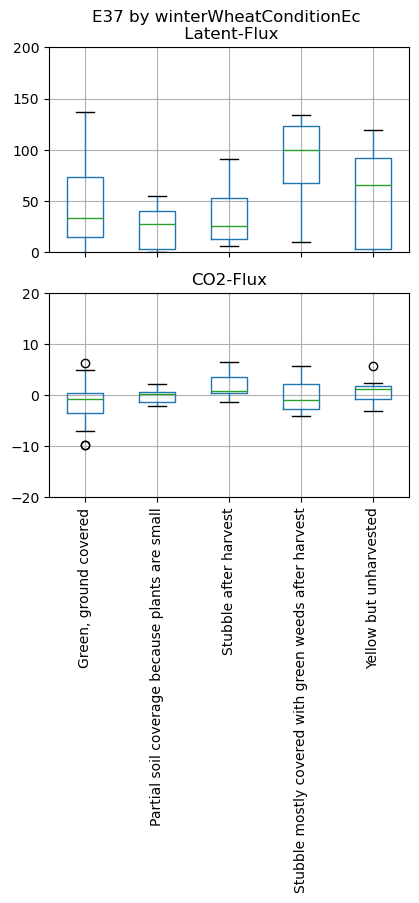

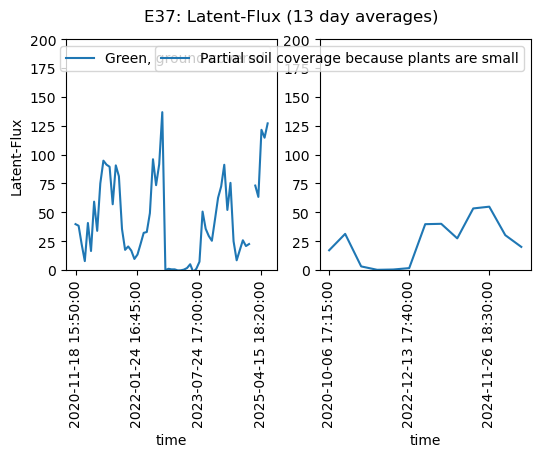

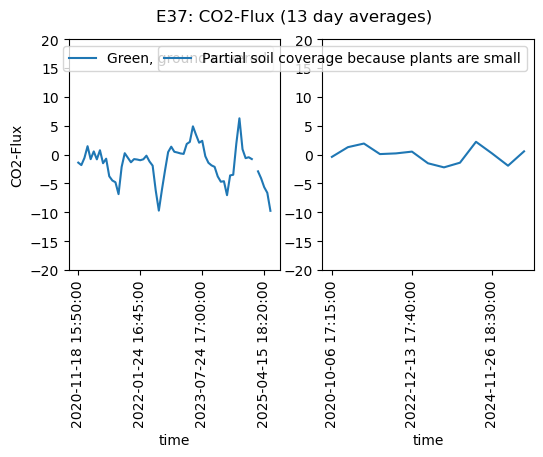

In [19]:
flux_type_1='Latent-Flux'
flux_type_2='CO2-Flux'
group_type='winterWheatConditionEc'

type_1=site_conditions[group_type].value_counts().index[0]
type_2=site_conditions[group_type].value_counts().index[1]

site_type_1=site_conditions[site_conditions[group_type]==type_1]
site_type_2=site_conditions[site_conditions[group_type]==type_2]

fig,ax=plt.subplots(2,1,figsize=(4.5,6))
site_conditions.boxplot(column=flux_type_1,by=group_type,rot=90,ax=ax[0])
site_conditions.boxplot(column=flux_type_2,by=group_type,rot=90,ax=ax[1])
plt.suptitle('');ax[0].set_xlabel('');ax[0].set_xticklabels('');ax[1].set_xlabel('')
ax[0].set_ylim([0,200]);ax[1].set_ylim([-20,20])
ax[0].set_title('{} by {} \n {}'.format(site,group_type,flux_type_1))

fig,ax=plt.subplots(1,2,figsize=(6,3))
site_type_1.plot('time',flux_type_1,rot=90,ax=ax[0])
site_type_2.plot('time',flux_type_1,rot=90,ax=ax[1])
ax[0].set_ylabel(flux_type_1)
ax[0].legend([type_1]);ax[1].legend([type_2])
plt.suptitle('{}: {} ({} day averages)'.format(site,flux_type_1,interval))
ax[0].set_ylim([0,200]);ax[1].set_ylim([0,200])

fig,ax=plt.subplots(1,2,figsize=(6,3))
site_type_1.plot('time',flux_type_2,rot=90,ax=ax[0])
site_type_2.plot('time',flux_type_2,rot=90,ax=ax[1])
ax[0].set_ylabel(flux_type_2)
ax[0].legend([type_1]);ax[1].legend([type_2])
plt.suptitle('{}: {} ({} day averages)'.format(site,flux_type_2,interval))
ax[0].set_ylim([-20,20]);ax[1].set_ylim([-20,20])

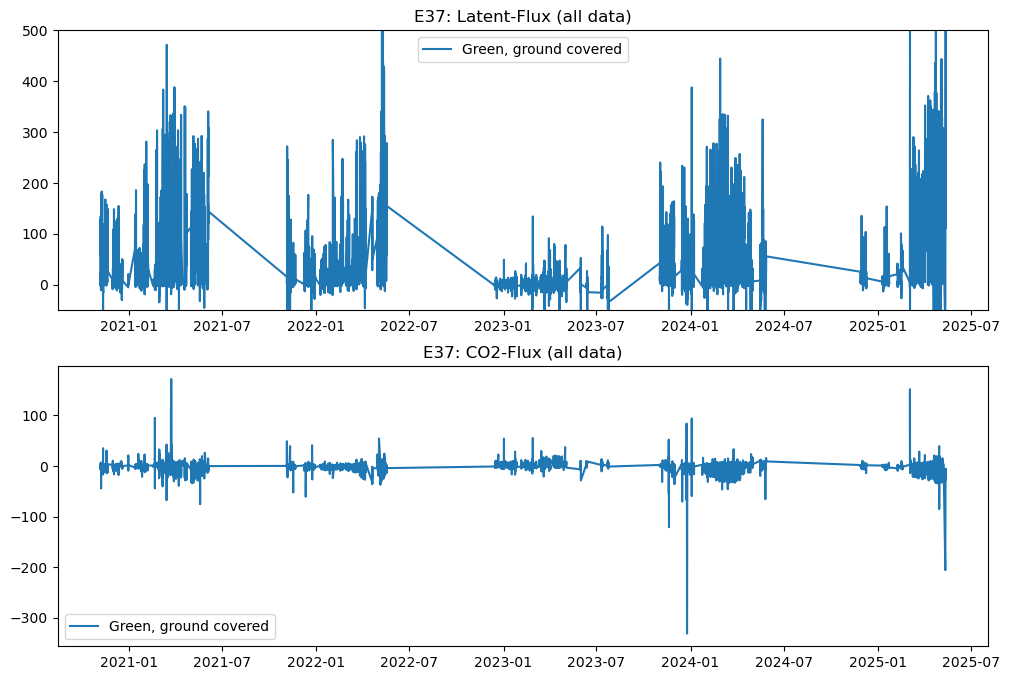

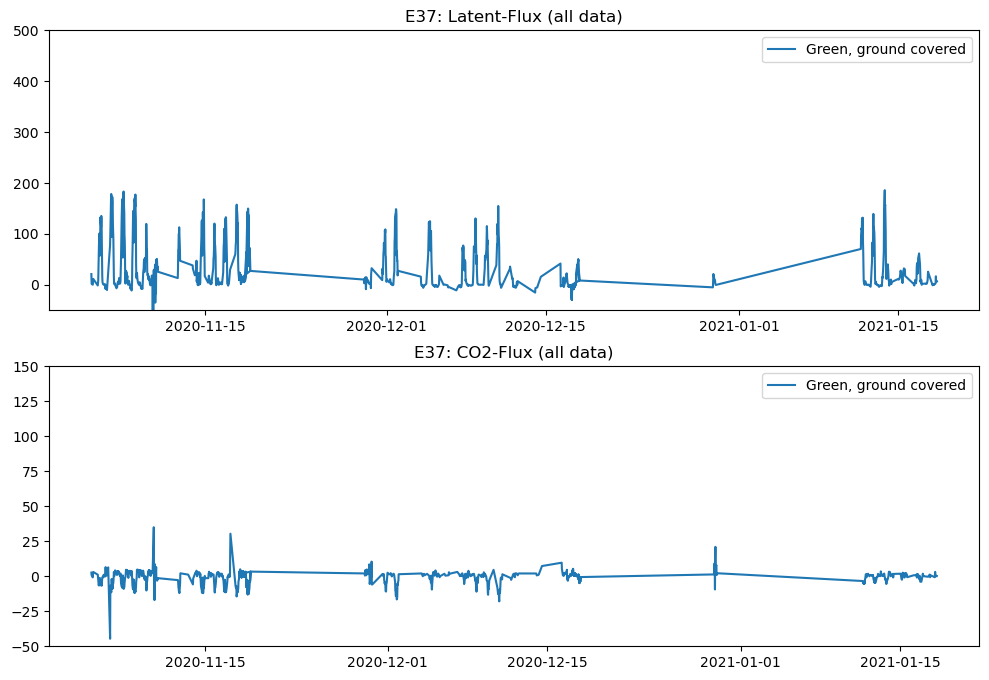

In [20]:
# plt.plot(latent_flux_E33_20200611.time,latent_flux_E33_20200611)

for k in range(0,len(site_type_1)): # len(site_croptype_1)
    if k==0:
        latent_flux_biweekly=globals()['latent_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_1.time.values[k]).strftime('%Y%m%d'))]
        co2_flux_biweekly=globals()['co2_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_1.time.values[k]).strftime('%Y%m%d'))]
    else:
        latent_flux_biweekly=xr.concat([latent_flux_biweekly,globals()['latent_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_1.time.values[k]).strftime('%Y%m%d'))]],'time')
        co2_flux_biweekly=xr.concat([co2_flux_biweekly,globals()['co2_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_1.time.values[k]).strftime('%Y%m%d'))]],'time')

# Set up the plot

fig,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(latent_flux_biweekly.time,latent_flux_biweekly)
ax[0].set_title('{}: {} (all data)'.format(site,flux_type_1,interval))
ax[0].set_ylim([-50,500])
ax[1].plot(co2_flux_biweekly.time,co2_flux_biweekly)
ax[1].set_title('{}: {} (all data)'.format(site,flux_type_2,interval))
ax[0].legend([type_1]);ax[1].legend([type_1])

# Same figure but zoomed in on certain indices

fig,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(latent_flux_biweekly.time[0:1000],latent_flux_biweekly[0:1000])
ax[0].set_title('{}: {} (all data)'.format(site,flux_type_1,interval))
ax[0].set_ylim([-50,500])
ax[1].plot(co2_flux_biweekly.time[0:1000],co2_flux_biweekly[0:1000])
ax[1].set_title('{}: {} (all data)'.format(site,flux_type_2,interval))
ax[0].legend([type_1]);ax[1].legend([type_1])
ax[1].set_ylim([-50,150])

del latent_flux_biweekly
del co2_flux_biweekly

(-50.0, 150.0)

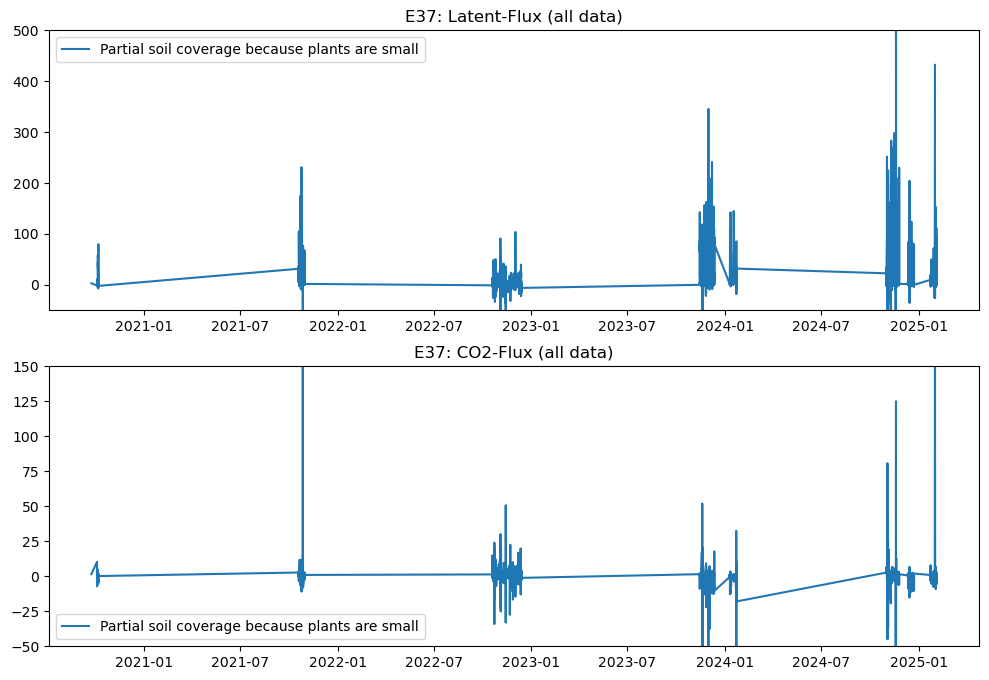

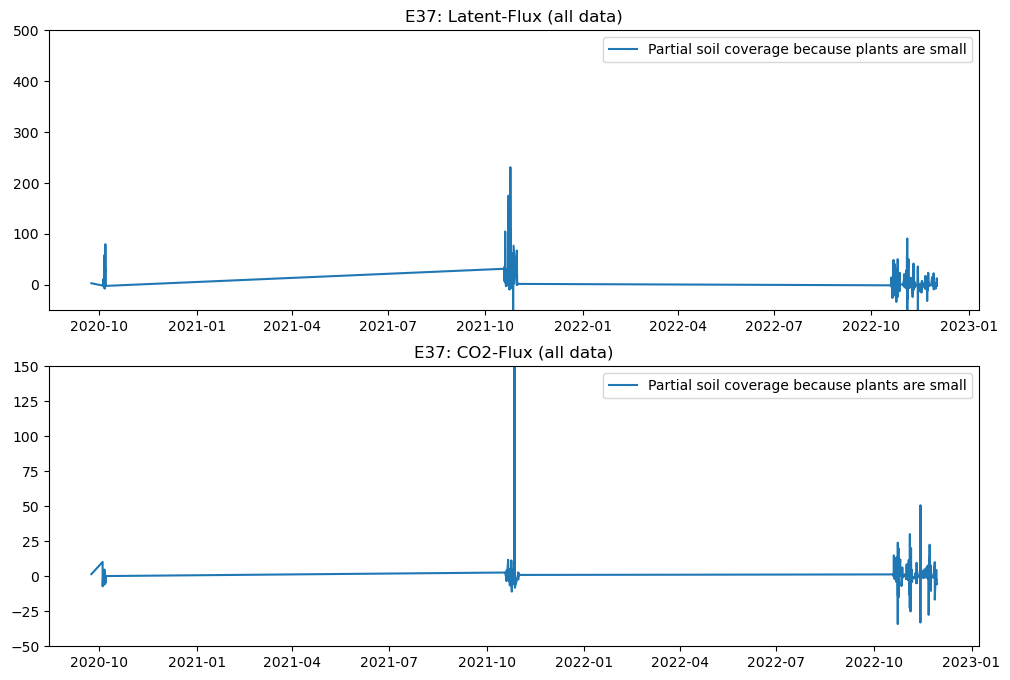

In [26]:
for k in range(0,len(site_type_2)): # len(site_croptype_1)
    if k==0:
        latent_flux_biweekly=globals()['latent_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_2.time.values[k]).strftime('%Y%m%d'))]
        co2_flux_biweekly=globals()['co2_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_2.time.values[k]).strftime('%Y%m%d'))]
    else:
        latent_flux_biweekly=xr.concat([latent_flux_biweekly,globals()['latent_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_2.time.values[k]).strftime('%Y%m%d'))]],'time')
        co2_flux_biweekly=xr.concat([co2_flux_biweekly,globals()['co2_flux_biweekly_{}_{}'.format(site,pd.to_datetime(site_type_2.time.values[k]).strftime('%Y%m%d'))]],'time')

# Set up the plot

fig,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(latent_flux_biweekly.time,latent_flux_biweekly)
ax[0].set_title('{}: {} (all data)'.format(site,flux_type_1,interval))
ax[0].set_ylim([-50,500])
ax[1].plot(co2_flux_biweekly.time,co2_flux_biweekly)
ax[1].set_title('{}: {} (all data)'.format(site,flux_type_2,interval))
ax[0].legend([type_2]);ax[1].legend([type_2])
ax[1].set_ylim([-50,150])

# Same figure but zoomed in on certain indices

fig,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(latent_flux_biweekly.time[0:1000],latent_flux_biweekly[0:1000])
ax[0].set_title('{}: {} (all data)'.format(site,flux_type_1,interval))
ax[0].set_ylim([-50,500])
ax[1].plot(co2_flux_biweekly.time[0:1000],co2_flux_biweekly[0:1000])
ax[1].set_title('{}: {} (all data)'.format(site,flux_type_2,interval))
ax[0].legend([type_2]);ax[1].legend([type_2])
ax[1].set_ylim([-50,150])